[paper](https://www.nature.com/articles/s41746-020-00372-6.pdf)  
[dataset](https://github.com/nshomron/covidpred)

## 1. Data Preprocessing

In [10]:
# # 安裝會使用到的套件
# !pip install xgboost
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)


In [1]:
# 確認當前工作目錄
%pwd

'c:\\Users\\betty\\D\\資管所\\Data_Mining\\project\\mid'

In [2]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn import metrics, ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

import seaborn as sns
import time

In [3]:
metadata = pd.read_csv("covid.csv") #匯資料
metadata.head(3)

C:\Users\betty\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other


In [430]:
# # 增加id
# metadata=metadata.assign(cov_id=metadata.index)

In [4]:
# 共有 278848 筆資料
metadata.shape

(278848, 10)

每個 class 的數量

In [5]:
fre=metadata['corona_result'].value_counts()
print(fre)

negative    260227
positive     14729
other         3892
Name: corona_result, dtype: int64


In [6]:
metadata['cough']=metadata['cough'].replace('None',np.nan)
metadata['fever']=metadata['fever'].replace('None',np.nan)
metadata['sore_throat']=metadata['sore_throat'].replace('None',np.nan)
metadata['shortness_of_breath']=metadata['shortness_of_breath'].replace('None',np.nan)
metadata['head_ache']=metadata['head_ache'].replace('None',np.nan)
metadata['gender']=metadata['gender'].replace(['female', 'male', 'None'], [0, 1, np.nan])
metadata['age_60_and_above']=metadata['age_60_and_above'].replace(['None', 'No', 'Yes'], [np.nan, 0 ,1])
metadata['test_indication']=metadata['test_indication'].replace(['Contact with confirmed', 'Other', 'Abroad'], [1, 0,0])

metadata

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,NaN,0.0,0
1,2020-04-30,1,0,0,0,0,negative,NaN,0.0,0
2,2020-04-30,0,1,0,0,0,negative,NaN,1.0,0
3,2020-04-30,1,0,0,0,0,negative,NaN,0.0,0
4,2020-04-30,1,0,0,0,0,negative,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...
278843,2020-03-11,0,0,0,0,0,negative,NaN,NaN,0
278844,2020-03-11,0,0,0,0,0,negative,NaN,NaN,0
278845,2020-03-11,0,0,0,0,0,positive,NaN,NaN,1
278846,2020-03-11,0,0,0,0,0,other,NaN,NaN,0


In [7]:
# drop_na=metadata.dropna()
# print(metadata[metadata['cough']==np.nan].count())
# print(metadata[metadata['fever']==np.nan])
# print(metadata[metadata['sore_throat']==np.nan])
# print(metadata[metadata['shortness_of_breath']==np.nan])
# print(metadata[metadata['head_ache']==np.nan])
# print(metadata[metadata['age_60_and_above']==np.nan])
# print(metadata[metadata['gender']==np.nan])

metadata.isnull().sum()

test_date                   0
cough                     252
fever                     252
sore_throat                 1
shortness_of_breath         1
head_ache                   1
corona_result               0
age_60_and_above       127320
gender                  19563
test_indication             0
dtype: int64

age_60_and_above的空值將近50%，欄位值為 0 或 1，以 random 填空值

In [8]:
drop_na = metadata
np.random.seed(2022)
drop_na.age_60_and_above.fillna(np.random.randint(0, 1), inplace =True)
drop_na.cough.fillna(np.random.randint(0, 1), inplace =True)
drop_na.fever.fillna(np.random.randint(0, 1), inplace =True)
drop_na.sore_throat.fillna(np.random.randint(0, 1), inplace =True)
drop_na.shortness_of_breath.fillna(np.random.randint(0, 1), inplace =True)
drop_na.head_ache.fillna(np.random.randint(0, 1), inplace =True)
drop_na.gender.fillna(np.random.randint(0, 1), inplace =True)
drop_na.test_indication.fillna(np.random.randint(0, 1), inplace =True)
# drop_na.age_60_and_above.fillna()
drop_na.isnull().sum()
# drop_na.shape

test_date              0
cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
corona_result          0
age_60_and_above       0
gender                 0
test_indication        0
dtype: int64

其他空值以前一個值填入

In [436]:
# drop_na.cough.fillna(method='ffill', inplace=True)
# drop_na.fever.fillna(method='ffill', inplace=True)
# drop_na.sore_throat.fillna(method='ffill', inplace=True)
# drop_na.shortness_of_breath.fillna(method='ffill', inplace=True)
# drop_na.head_ache.fillna(method='ffill', inplace=True)
# # drop_na.age_60_and_above.fillna(method='ffill', inplace=True)
# drop_na.gender.fillna(method='ffill', inplace=True)
# drop_na.test_indication.fillna(method='ffill', inplace=True)
# drop_na.isnull().sum()


test_date              0
cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
corona_result          0
age_60_and_above       0
gender                 0
test_indication        0
cov_id                 0
dtype: int64

## 2. 將資料分為測試集和訓練集


### 2.1 over-sampling

#### 2.1.1 all features

In [15]:
y= drop_na.corona_result

features_all=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
X_all =drop_na[features_all]

In [18]:
ros = RandomOverSampler(random_state=0)
X_resampled_all, y_resampled_all = ros.fit_resample(X_all, y)
from collections import Counter
print(sorted(Counter(y_resampled_all).items()))

[('negative', 260227), ('other', 260227), ('positive', 260227)]


#### 2.1.2 filtered features

In [17]:
features_filter=['cough', 'fever', 'age_60_and_above', 'gender', 'test_indication']
X_filter =drop_na[features_filter]

In [19]:
ros = RandomOverSampler(random_state=0)
X_resampled_filter, y_resampled_filter = ros.fit_resample(X_filter, y)
from collections import Counter
print(sorted(Counter(y_resampled_filter).items()))

[('negative', 260227), ('other', 260227), ('positive', 260227)]


### 2.2. 根據4:1的比例切分資料集 

利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 4:1，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

#### 2.2.1 all features

In [21]:
# y= drop_na.corona_result

# features_all=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
# X_all =drop_na[features_all]

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_resampled_all, y_resampled_all, test_size=0.2, random_state=2022)

#### 2.2.2 filtered features

In [22]:
# y= drop_na.corona_result

# features_filter=['cough', 'fever', 'age_60_and_above', 'gender', 'test_indication']
# X_filter =drop_na[features_filter]

X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_resampled_filter, y_resampled_filter, test_size=0.25, random_state=2022)

In [23]:
print(f"raw data percentage :\n{metadata['corona_result'].value_counts(normalize=True) * 100}")
print(f"raw data :\n{metadata['corona_result'].value_counts()}")


raw data percentage :
negative    93.322168
positive     5.282089
other        1.395742
Name: corona_result, dtype: float64
raw data :
negative    260227
positive     14729
other         3892
Name: corona_result, dtype: int64


In [24]:
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

### 2.2. Gradient Boosting

#### 2.2.1 Gradient Boosting (all)

In [25]:
model_type="Gradient Boosting (all)"
gb_all = GradientBoostingClassifier()
gb_all.fit(X_train_all, y_train_all)

GradientBoostingClassifier()

In [26]:
predicted_all = gb_all.predict(X_test_all)
predicted_prob_all = gb_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

In [27]:
# Get numerical feature importances
importances = list(gb_all.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_all, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.63
Variable: fever                Importance: 0.17
Variable: head_ache            Importance: 0.08
Variable: cough                Importance: 0.04
Variable: sore_throat          Importance: 0.03
Variable: shortness_of_breath  Importance: 0.03
Variable: age_60_and_above     Importance: 0.01
Variable: gender               Importance: 0.0


Accuracy: 0.56
Auc: 0.75
Detail:
              precision    recall  f1-score   support

    negative       0.47      0.77      0.59     52176
       other       0.41      0.17      0.24     52133
    positive       0.79      0.76      0.77     51828

    accuracy                           0.56    156137
   macro avg       0.56      0.57      0.53    156137
weighted avg       0.56      0.56      0.53    156137



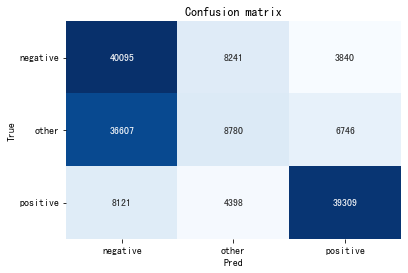

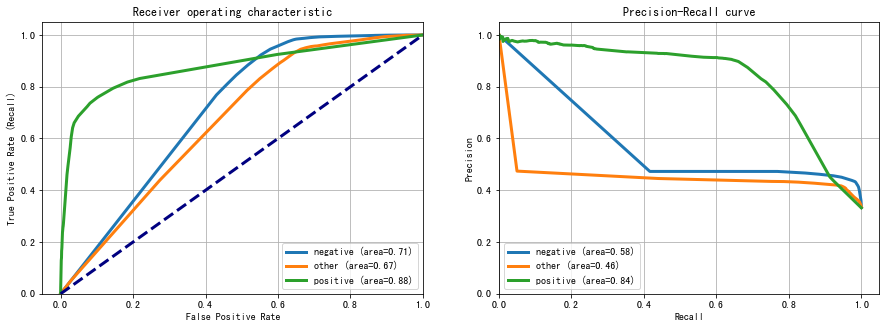

In [28]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all, average='weighted')
precision_all=precision_score(y_test_all, predicted_all, average='weighted')
recall_all=recall_score(y_test_all, predicted_all, average='weighted')

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1, 'Recall':recall_all, 'Precision':precision_all}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

In [29]:
print(precision_all)
print(recall_all)

0.556339244182463
0.5647860532737276


#### 2.2.1 Gradient Boosting (filtered)

In [30]:
model_type="Gradient Boosting (filtered)"
gb_filter = GradientBoostingClassifier()
gb_filter.fit(X_train_filter, y_train_filter)

GradientBoostingClassifier()

In [31]:
predicted_filter = gb_filter.predict(X_test_filter)
predicted_prob_filter = gb_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

In [32]:
# Get numerical feature importances
importances = list(gb_filter.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_filter, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.72
Variable: fever                Importance: 0.21
Variable: cough                Importance: 0.05
Variable: age_60_and_above     Importance: 0.02
Variable: gender               Importance: 0.0


Accuracy: 0.55
Auc: 0.74
Detail:
              precision    recall  f1-score   support

    negative       0.47      0.77      0.58     65323
       other       0.41      0.13      0.19     65092
    positive       0.72      0.76      0.74     64756

    accuracy                           0.55    195171
   macro avg       0.53      0.55      0.50    195171
weighted avg       0.53      0.55      0.50    195171



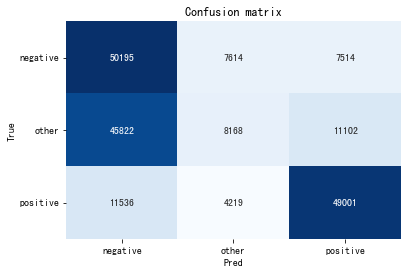

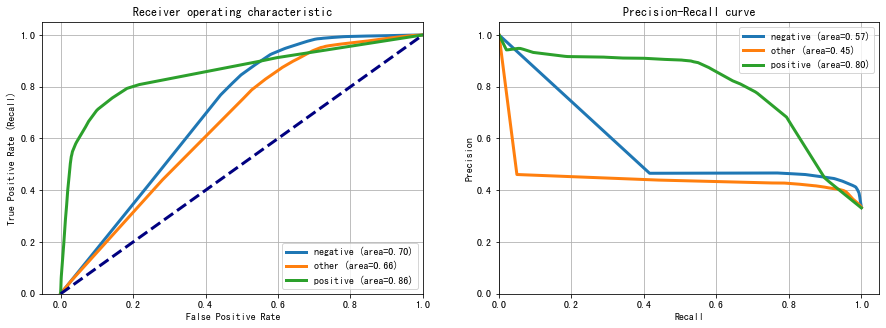

In [33]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter, average='weighted')
precision_filter=precision_score(y_test_filter, predicted_filter, average='weighted')
recall_filter=recall_score(y_test_filter, predicted_filter, average='weighted')

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1, 'Recall': recall_filter, 'Precision':precision_filter
}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.3. Decision Tree

#### 2.3.1 Decision Tree (all)

In [34]:
dt_all = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=16)
dt_all.fit(X_train_all, y_train_all)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=16)

In [35]:
model_type="Decision Tree (all)"
predicted_all = dt_all.predict(X_test_all)
predicted_prob_all = dt_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

In [36]:
# Get numerical feature importances
importances = list(dt_all.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_all, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.61
Variable: fever                Importance: 0.19
Variable: head_ache            Importance: 0.09
Variable: cough                Importance: 0.04
Variable: sore_throat          Importance: 0.03
Variable: shortness_of_breath  Importance: 0.02
Variable: age_60_and_above     Importance: 0.01
Variable: gender               Importance: 0.0


[Text(0.7023809523809523, 0.9375, 'test_indication <= 0.5\nentropy = 1.585\nsamples = 624544\nvalue = [208051, 208094, 208399]\nclass = positive'),
 Text(0.5, 0.8125, 'fever <= 0.5\nentropy = 1.527\nsamples = 509638\nvalue = [205524, 199407, 104707]\nclass = negative'),
 Text(0.3333333333333333, 0.6875, 'head_ache <= 0.5\nentropy = 1.447\nsamples = 438241\nvalue = [193476, 182524, 62241]\nclass = negative'),
 Text(0.2857142857142857, 0.5625, 'cough <= 0.5\nentropy = 1.428\nsamples = 431976\nvalue = [193445, 182199, 56332]\nclass = negative'),
 Text(0.19047619047619047, 0.4375, 'sore_throat <= 0.5\nentropy = 1.379\nsamples = 379835\nvalue = [176036, 163902, 39897]\nclass = negative'),
 Text(0.14285714285714285, 0.3125, 'shortness_of_breath <= 0.5\nentropy = 1.372\nsamples = 378313\nvalue = [175996, 163796, 38521]\nclass = negative'),
 Text(0.09523809523809523, 0.1875, 'gender <= 0.5\nentropy = 1.367\nsamples = 377054\nvalue = [175924, 163702, 37428]\nclass = negative'),
 Text(0.04761904

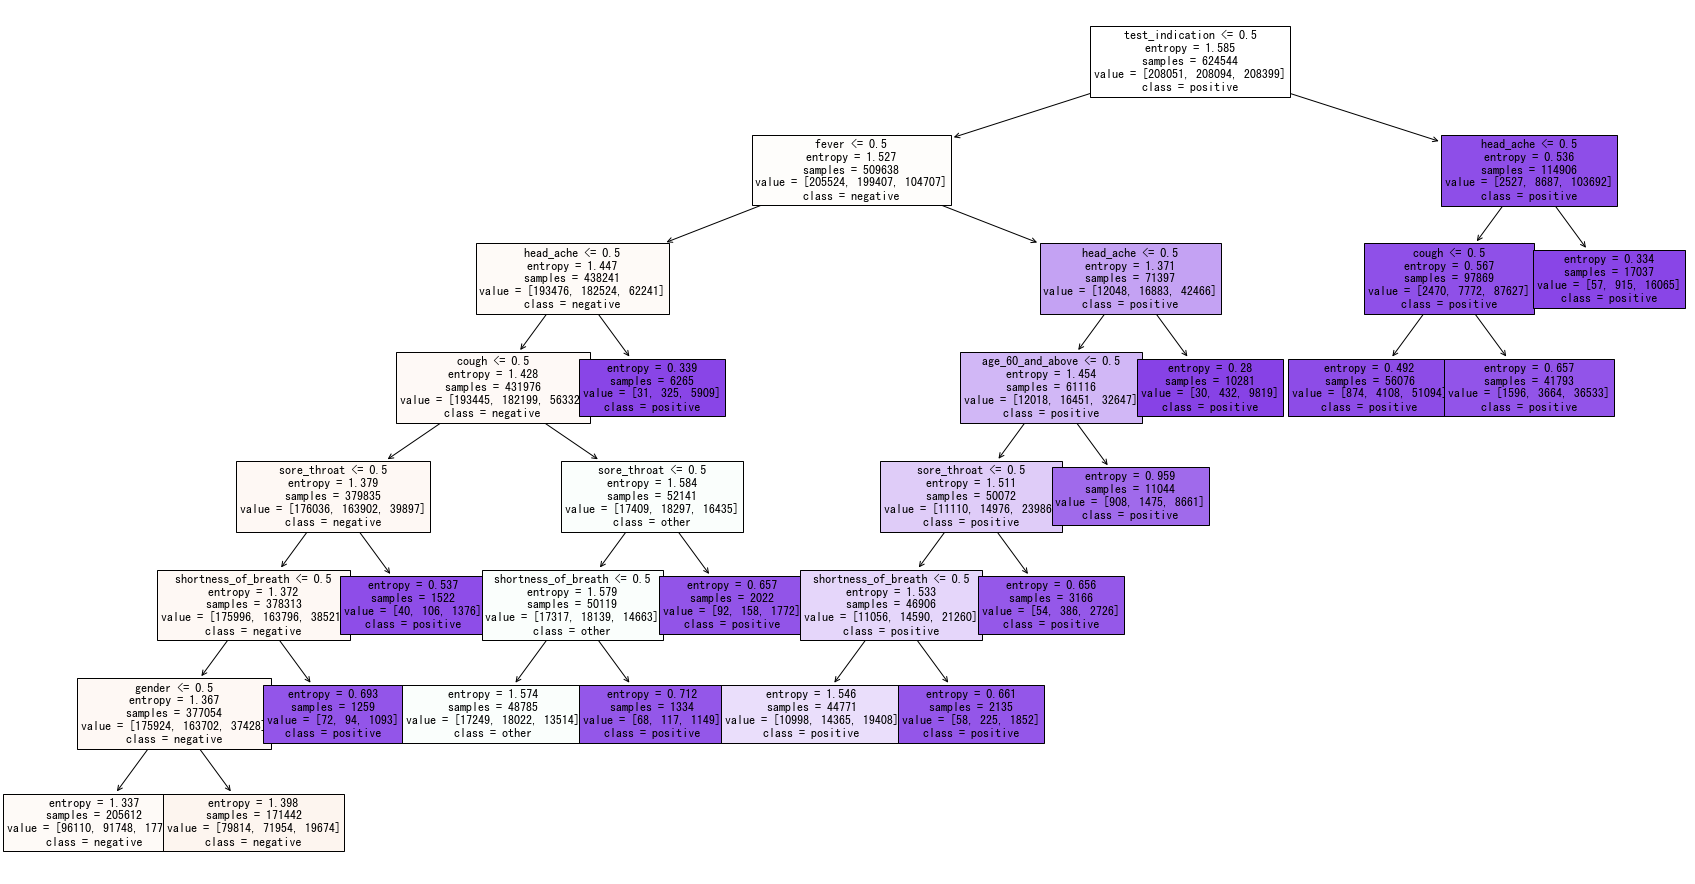

In [37]:
class_name=['negative', 'other', 'positive']
fig=plt.figure(figsize=(30, 16))
plot_tree(dt_all, 
          feature_names=features_all,
          class_names=class_name,
          fontsize=12,
          filled=True)

In [38]:
# get the best parameters : max_leaf=5, min_samples=20，accuracy=0.987

def get_mae(max_leaf, min_samples, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes= max_leaf, min_samples_split = min_samples, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    accuracy = accuracy_score(val_y, preds_val)
    print(f"max_leaf = {max_leaf}, min_samples = {min_samples}, accuracy = {accuracy}")
    return(accuracy)

candidate_max_leaf_nodes = [2, 4, 5, 6, 8, 10, 12, 14, 16]
candidate_min_samples = [20, 30, 40]

for num in candidate_max_leaf_nodes:
    for num2 in candidate_min_samples:
        get_mae(num, num2, X_train_all, X_test_all, y_train_all, y_test_all)

max_leaf = 2, min_samples = 20, accuracy = 0.4955199600350974
max_leaf = 2, min_samples = 30, accuracy = 0.4955199600350974
max_leaf = 2, min_samples = 40, accuracy = 0.4955199600350974
max_leaf = 4, min_samples = 20, accuracy = 0.5522201656237791
max_leaf = 4, min_samples = 30, accuracy = 0.5522201656237791
max_leaf = 4, min_samples = 40, accuracy = 0.5522201656237791
max_leaf = 5, min_samples = 20, accuracy = 0.5535843522035135
max_leaf = 5, min_samples = 30, accuracy = 0.5535843522035135
max_leaf = 5, min_samples = 40, accuracy = 0.5535843522035135
max_leaf = 6, min_samples = 20, accuracy = 0.5535843522035135
max_leaf = 6, min_samples = 30, accuracy = 0.5535843522035135
max_leaf = 6, min_samples = 40, accuracy = 0.5535843522035135
max_leaf = 8, min_samples = 20, accuracy = 0.5573502757194003
max_leaf = 8, min_samples = 30, accuracy = 0.5573502757194003
max_leaf = 8, min_samples = 40, accuracy = 0.5573502757194003
max_leaf = 10, min_samples = 20, accuracy = 0.5598160589738499
max_lea

Accuracy: 0.56
Auc: 0.75
Detail:
              precision    recall  f1-score   support

    negative       0.47      0.85      0.60     52176
       other       0.37      0.09      0.14     52133
    positive       0.79      0.75      0.77     51828

    accuracy                           0.56    156137
   macro avg       0.54      0.56      0.50    156137
weighted avg       0.54      0.56      0.50    156137



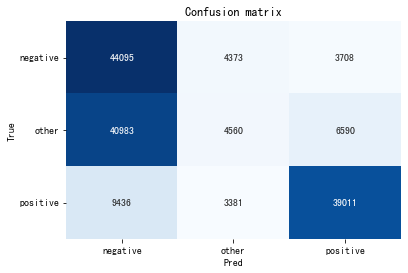

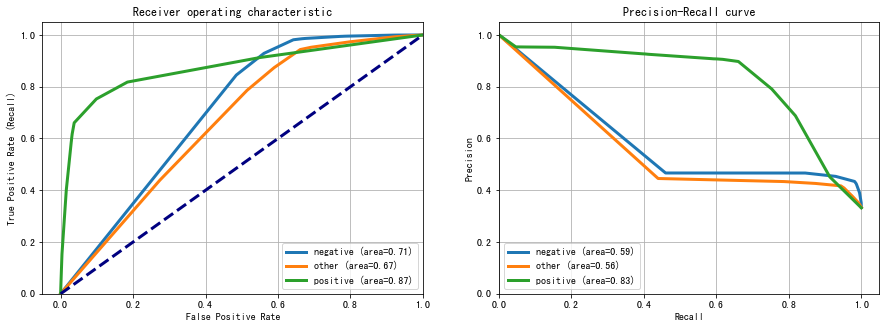

In [39]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all, average='weighted')
precision_all=precision_score(y_test_all, predicted_all, average='weighted')
recall_all=recall_score(y_test_all, predicted_all, average='weighted')

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1 , 'Precision':precision_all,'Recall':recall_all}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 2.3.2 Decision Tree (filtered)

In [40]:
# get the best parameters : max_leaf=5, min_samples=20，accuracy=0.987

def get_mae(max_leaf, min_samples, train_X, val_X, train_y, val_y):
    model = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes= max_leaf, min_samples_split = min_samples, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    accuracy = accuracy_score(val_y, preds_val)
    print(f"max_leaf = {max_leaf}, min_samples = {min_samples}, accuracy = {accuracy}")
    return(accuracy)

candidate_max_leaf_nodes = [2, 3, 4, 5, 6, 8, 10, 12, 14, 16]
candidate_min_samples = [20, 30, 40]

for num in candidate_max_leaf_nodes:
    for num2 in candidate_min_samples:
        get_mae(num, num2, X_train_filter, X_test_filter, y_train_filter, y_test_filter)

max_leaf = 2, min_samples = 20, accuracy = 0.4956781489053189
max_leaf = 2, min_samples = 30, accuracy = 0.4956781489053189
max_leaf = 2, min_samples = 40, accuracy = 0.4956781489053189
max_leaf = 3, min_samples = 20, accuracy = 0.5435643615086257
max_leaf = 3, min_samples = 30, accuracy = 0.5435643615086257
max_leaf = 3, min_samples = 40, accuracy = 0.5435643615086257
max_leaf = 4, min_samples = 20, accuracy = 0.546279928882877
max_leaf = 4, min_samples = 30, accuracy = 0.546279928882877
max_leaf = 4, min_samples = 40, accuracy = 0.546279928882877
max_leaf = 5, min_samples = 20, accuracy = 0.546279928882877
max_leaf = 5, min_samples = 30, accuracy = 0.546279928882877
max_leaf = 5, min_samples = 40, accuracy = 0.546279928882877
max_leaf = 6, min_samples = 20, accuracy = 0.546279928882877
max_leaf = 6, min_samples = 30, accuracy = 0.546279928882877
max_leaf = 6, min_samples = 40, accuracy = 0.546279928882877
max_leaf = 8, min_samples = 20, accuracy = 0.5473046712882549
max_leaf = 8, min

In [65]:
dt_filter = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=14)
dt_filter.fit(X_train_filter, y_train_filter)

DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=14)

In [66]:
model_type="Decision Tree (filterd)"
predicted_filter = dt_filter.predict(X_test_filter)
predicted_prob_filter = dt_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

In [67]:
# Get numerical feature importances
importances = list(dt_filter.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_filter, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.7
Variable: fever                Importance: 0.22
Variable: cough                Importance: 0.07
Variable: age_60_and_above     Importance: 0.02
Variable: gender               Importance: 0.0


[Text(0.6761363636363636, 0.9166666666666666, 'test_indication <= 0.5\nentropy = 1.585\nsamples = 585510\nvalue = [194904, 195135, 195471]\nclass = positive'),
 Text(0.48863636363636365, 0.75, 'fever <= 0.5\nentropy = 1.527\nsamples = 477725\nvalue = [192547, 187003, 98175]\nclass = negative'),
 Text(0.29545454545454547, 0.5833333333333334, 'cough <= 0.5\nentropy = 1.447\nsamples = 410750\nvalue = [181258, 171151, 58341]\nclass = negative'),
 Text(0.18181818181818182, 0.4166666666666667, 'gender <= 0.5\nentropy = 1.392\nsamples = 358753\nvalue = [164955, 153794, 40004]\nclass = negative'),
 Text(0.09090909090909091, 0.25, 'age_60_and_above <= 0.5\nentropy = 1.366\nsamples = 195978\nvalue = [90227, 86355, 19396]\nclass = negative'),
 Text(0.045454545454545456, 0.08333333333333333, 'entropy = 1.361\nsamples = 175060\nvalue = [81534, 76615, 16911]\nclass = negative'),
 Text(0.13636363636363635, 0.08333333333333333, 'entropy = 1.405\nsamples = 20918\nvalue = [8693, 9740, 2485]\nclass = oth

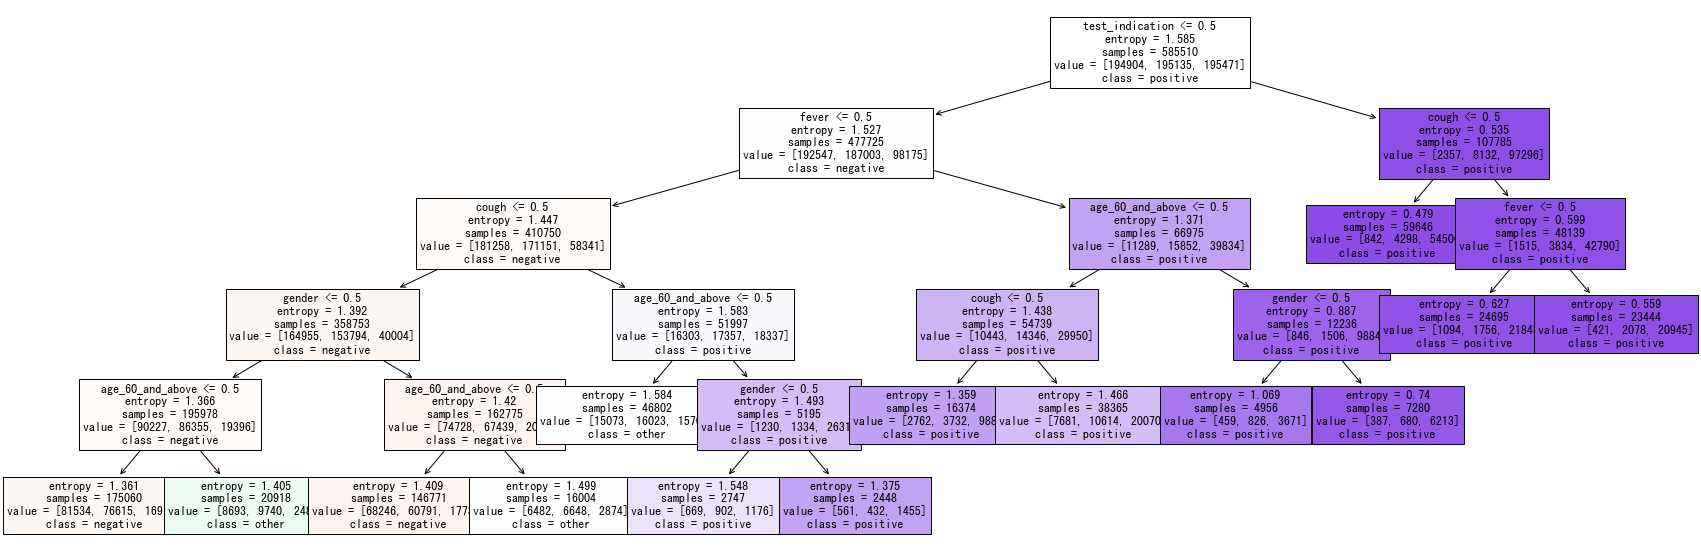

In [68]:
class_name=['negative', 'other', 'positive']
fig=plt.figure(figsize=(30, 10))
plot_tree(dt_filter, 
          feature_names=features_filter,
          class_names=class_name,
          fontsize=12,
          filled=True)

Accuracy: 0.55
Auc: 0.74
Detail:
              precision    recall  f1-score   support

    negative       0.47      0.77      0.58     65323
       other       0.39      0.17      0.23     65092
    positive       0.77      0.71      0.74     64756

    accuracy                           0.55    195171
   macro avg       0.54      0.55      0.52    195171
weighted avg       0.54      0.55      0.52    195171



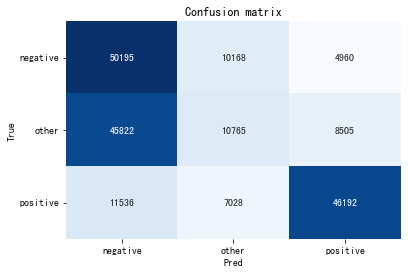

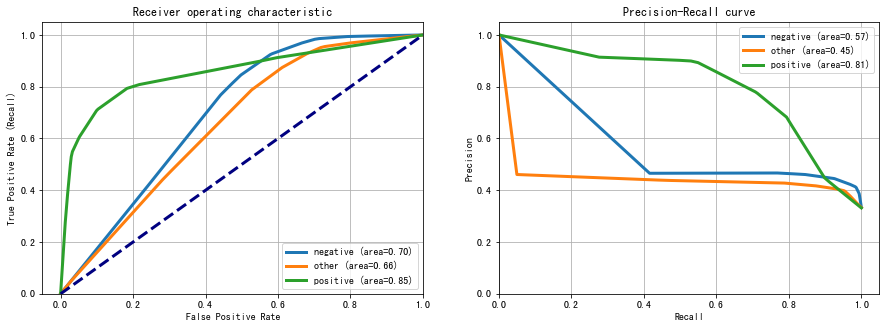

In [69]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter, average='weighted')
precision_filter=precision_score(y_test_filter, predicted_filter, average='weighted')
recall_filter=recall_score(y_test_filter, predicted_filter, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1, 'Precision':precision_filter, 'Recall': recall_filter}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.4. Random Forest

#### 2.4.1 Random Forest (all)

In [46]:
rf_all = ensemble.RandomForestClassifier()
rf_all.fit(X_train_all, y_train_all)

RandomForestClassifier()

In [47]:
model_type="Random Forest (all)"
predicted_all = rf_all.predict(X_test_all)
predicted_prob_all = rf_all.predict_proba(X_test_all)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

In [48]:
# Get numerical feature importances
importances = list(rf_all.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_all, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.54
Variable: fever                Importance: 0.16
Variable: head_ache            Importance: 0.11
Variable: cough                Importance: 0.09
Variable: sore_throat          Importance: 0.05
Variable: shortness_of_breath  Importance: 0.04
Variable: age_60_and_above     Importance: 0.01
Variable: gender               Importance: 0.01


Accuracy: 0.56
Auc: 0.75
Detail:
              precision    recall  f1-score   support

    negative       0.47      0.77      0.59     52176
       other       0.41      0.17      0.24     52133
    positive       0.79      0.76      0.77     51828

    accuracy                           0.56    156137
   macro avg       0.56      0.57      0.53    156137
weighted avg       0.56      0.56      0.53    156137



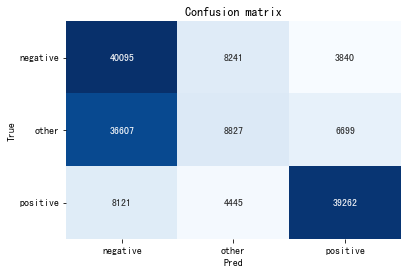

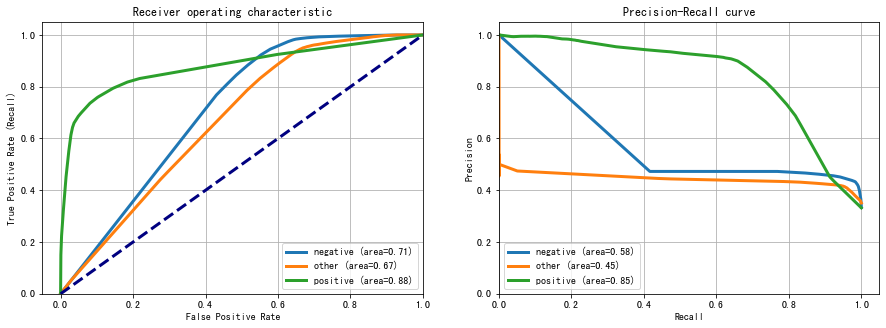

In [49]:
classes = np.unique(y_test_all)
y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_all, predicted_all)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
                            multi_class="ovr")
f1=f1_score(y_test_all, predicted_all, average='weighted')
precision_all=precision_score(y_test_all, predicted_all, average='weighted')
recall_all=recall_score(y_test_all, predicted_all, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_all, predicted_all))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_all, predicted_all)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_all[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_all[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1, 'Precision':precision_all, 'Recall':recall_all }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

#### 2.4.2 Random Forest (filtered)

In [50]:
rf_filter = ensemble.RandomForestClassifier()
rf_filter.fit(X_train_filter, y_train_filter)

RandomForestClassifier()

In [51]:
model_type="Random Forest (filered)"
predicted_filter = rf_filter.predict(X_test_filter)
predicted_prob_filter = rf_filter.predict_proba(X_test_filter)

# accuracy=accuracy_score(y_test, predicted)
# confusion=confusion_matrix(y_test, predicted)

# print("Accurracy: ", accuracy)
# print("Confusion Matrix: ", confusion)

In [52]:
# Get numerical feature importances
importances = list(rf_filter.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_filter, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: test_indication      Importance: 0.66
Variable: fever                Importance: 0.2
Variable: cough                Importance: 0.12
Variable: age_60_and_above     Importance: 0.01
Variable: gender               Importance: 0.0


Accuracy: 0.55
Auc: 0.74
Detail:
              precision    recall  f1-score   support

    negative       0.47      0.77      0.58     65323
       other       0.41      0.13      0.19     65092
    positive       0.72      0.76      0.74     64756

    accuracy                           0.55    195171
   macro avg       0.53      0.55      0.50    195171
weighted avg       0.53      0.55      0.50    195171



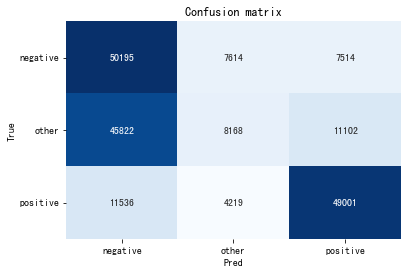

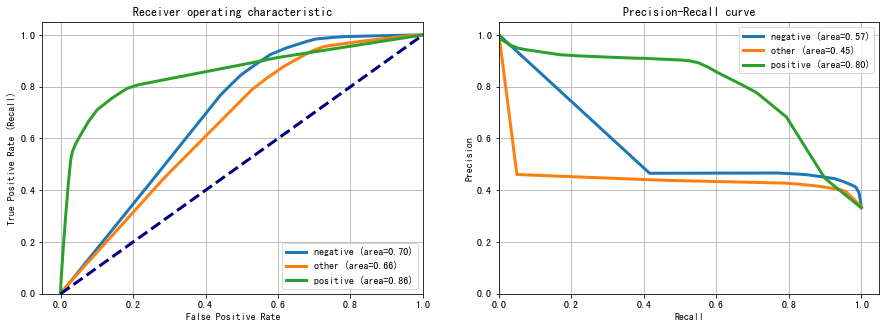

In [53]:
classes = np.unique(y_test_filter)
y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
                            multi_class="ovr")
f1=f1_score(y_test_filter, predicted_filter, average='weighted')
precision_filter=precision_score(y_test_filter, predicted_filter, average='weighted')
recall_filter=recall_score(y_test_filter, predicted_filter, average='weighted')
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test_filter, predicted_filter))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
roc_auc_dict = {}
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob_filter[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    ax[0].plot(fpr, tpr, lw=3, 
            #   label='{0} (area={1:0.2f})'.format(classes[i], 
            #                   metrics.auc(fpr, tpr))
                label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
               )
    roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob_filter[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1, 'Precision':precision_filter, 'Recall':recall_filter}
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 2.5. AdaBoost

In [54]:
# xgb = XGBClassifier(learning_rate=0.01,
#                       n_estimators=20,           # 树的个数-10棵树建立xgboost
#                       max_depth=10,               # 树的深度
#                       min_child_weight = 1,      # 叶子节点最小权重
#                       gamma=0.,                  # 惩罚项中叶子结点个数前的参数
#                       subsample=1,               # 所有样本建立决策树
#                       colsample_btree=1,         # 所有特征建立决策树
#                       scale_pos_weight=1,        # 解决样本个数不平衡的问题
#                       random_state=42,           # 随机数
#                       slient = 0
#                       )
# xgb.fit(X_train_all,y_train_all)

#### 2.5.1 AdaBoost (all)

In [55]:
# ada_all = AdaBoostClassifier(base_estimator=None, n_estimators=50,learning_rate=0.02, algorithm= "SAMME.R" ,random_state=42)

# ada_all.fit(X_train_all, y_train_all)

In [56]:
# model_type="AdaBoost (all)"
# predicted_all = ada_all.predict(X_test_all)
# predicted_prob_all = ada_all.predict_proba(X_test_all)

# # accuracy=accuracy_score(y_test, predicted)
# # confusion=confusion_matrix(y_test, predicted)

# # print("Accurracy: ", accuracy)
# # print("Confusion Matrix: ", confusion)

In [57]:
# classes = np.unique(y_test_all)
# y_test_array = pd.get_dummies(y_test_all, drop_first=False).values

# ## Accuracy, Precision, Recall
# accuracy = metrics.accuracy_score(y_test_all, predicted_all)
# auc = metrics.roc_auc_score(y_test_array, predicted_prob_all, 
#                             multi_class="ovr")
# f1=f1_score(y_test_all, predicted_all, average='weighted')
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(y_test_all, predicted_all))
    
# ## Plot confusion matrix
# cm = metrics.confusion_matrix(y_test_all, predicted_all)
# fig, ax = plt.subplots()
# sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
#             cbar=False)
# ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
#        yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# ## Plot roc
# roc_auc_dict = {}
# for i in range(len(classes)):
#     fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
#                            predicted_prob_all[:,i])
#     roc_auc = metrics.auc(fpr, tpr)
#     ax[0].plot(fpr, tpr, lw=3, 
#             #   label='{0} (area={1:0.2f})'.format(classes[i], 
#             #                   metrics.auc(fpr, tpr))
#                 label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
#                )
#     roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
# ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
# ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
#           xlabel='False Positive Rate', 
#           ylabel="True Positive Rate (Recall)", 
#           title="Receiver operating characteristic")
# ax[0].legend(loc="lower right")
# ax[0].grid(True)
    
# ## Plot precision-recall curve
# for i in range(len(classes)):
#     precision, recall, thresholds = metrics.precision_recall_curve(
#                  y_test_array[:,i], predicted_prob_all[:,i])
#     ax[1].plot(recall, precision, lw=3, 
#                label='{0} (area={1:0.2f})'.format(classes[i], 
#                                   metrics.auc(recall, precision))
#               )
# ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
#           ylabel="Precision", title="Precision-Recall curve")
# ax[1].legend(loc="best")
# ax[1].grid(True)
# plt.show()

# # 把結果加進result_df
# result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc, 'F1-score': f1 }
#                              , ignore_index=True)
# roc_auc_all[model_type] = roc_auc

#### 2.5.2 AdaBoost (filtered)

In [58]:
# ada_filter = AdaBoostClassifier(base_estimator=None, n_estimators=50,learning_rate=0.02, algorithm= "SAMME.R" ,random_state=42)

# ada_filter.fit(X_train_filter, y_train_filter)

In [59]:
# model_type="AdaBoost (filered)"
# predicted_filter = ada_filter.predict(X_test_filter)
# predicted_prob_filter = ada_filter.predict_proba(X_test_filter)

# # accuracy=accuracy_score(y_test, predicted)
# # confusion=confusion_matrix(y_test, predicted)

# # print("Accurracy: ", accuracy)
# # print("Confusion Matrix: ", confusion)

In [60]:
# classes = np.unique(y_test_filter)
# y_test_array = pd.get_dummies(y_test_filter, drop_first=False).values

# ## Accuracy, Precision, Recall
# accuracy = metrics.accuracy_score(y_test_filter, predicted_filter)
# auc = metrics.roc_auc_score(y_test_array, predicted_prob_filter, 
#                             multi_class="ovr")
# f1=f1_score(y_test_filter, predicted_filter, average='weighted')
# print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
# print("Detail:")
# print(metrics.classification_report(y_test_filter, predicted_filter))
    
# ## Plot confusion matrix
# cm = metrics.confusion_matrix(y_test_filter, predicted_filter)
# fig, ax = plt.subplots()
# sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
#             cbar=False)
# ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
#        yticklabels=classes, title="Confusion matrix")
# plt.yticks(rotation=0)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# ## Plot roc
# roc_auc_dict = {}
# for i in range(len(classes)):
#     fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
#                            predicted_prob_filter[:,i])
#     roc_auc = metrics.auc(fpr, tpr)
#     ax[0].plot(fpr, tpr, lw=3, 
#             #   label='{0} (area={1:0.2f})'.format(classes[i], 
#             #                   metrics.auc(fpr, tpr))
#                 label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
#                )
#     roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
    
# ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
# ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
#           xlabel='False Positive Rate', 
#           ylabel="True Positive Rate (Recall)", 
#           title="Receiver operating characteristic")
# ax[0].legend(loc="lower right")
# ax[0].grid(True)
    
# ## Plot precision-recall curve
# for i in range(len(classes)):
#     precision, recall, thresholds = metrics.precision_recall_curve(
#                  y_test_array[:,i], predicted_prob_filter[:,i])
#     ax[1].plot(recall, precision, lw=3, 
#                label='{0} (area={1:0.2f})'.format(classes[i], 
#                                   metrics.auc(recall, precision))
#               )
# ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
#           ylabel="Precision", title="Precision-Recall curve")
# ax[1].legend(loc="best")
# ax[1].grid(True)
# plt.show()

# # 把結果加進result_df
# result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc , 'F1-score': f1}
#                              , ignore_index=True)
# roc_auc_all[model_type] = roc_auc

### 2.6. 比較

In [61]:
result_df.sort_values(by=['F1-score'], ascending=False)

,model_type,Accuracy,AUC,F1-score,Precision,Recall
4,Random Forest (all),0.564786,0.752638,0.532112,0.556651,0.564786
0,Gradient Boosting (all),0.564786,0.751599,0.531858,0.556339,0.564786
2,Decision Tree (all),0.561468,0.748105,0.504226,0.542163,0.561468
1,Gradient Boosting (filtered),0.550102,0.737613,0.504028,0.532846,0.550102
3,Decision Tree (filterd),0.550102,0.737764,0.504028,0.532846,0.550102
5,Random Forest (filered),0.550102,0.737764,0.504028,0.532846,0.550102


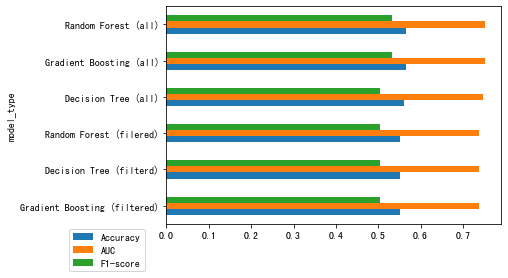

In [62]:
result_df.sort_values(by=['F1-score'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC", "F1-score"])
plt.legend(bbox_to_anchor=(-0.05,0))